###  아래 가이드에 따라서 1000명의 고객 구매데이터를 생성하고 아래사항을 수행하세요(관측치 10000개)

#### Q1. 고객 속성(id, 성별, 연령, 거주지역) 데이터와 거래 데이터를 통합한 데이터 프레임 df를 생성하세요.

In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 고객 데이터프레임
cusno = np.arange(1001,2001)
gender = np.random.randint(0,2,size=1000)
age = np.random.randint(10,81,size=1000)
region = np.random.randint(1,11,size=1000)

cus = pd.DataFrame({'cusno':cusno,'gender':gender,'age':age,'region':region})

# 거래 데이터프레임
trans_id = random.sample(list(range(10001,50000)), 10000)
cusno = np.random.randint(1001,2001, size=10000)
date = pd.date_range(start='2020-01-01', end='2021-12-31', periods=10000, normalize=True)
day = date.day_name
product_20 = np.random.choice([10,20,30], 10000) # 10:고가, 20:중가, 30:저가
product_21 = np.random.choice([10,20,30], 10000)
price_20 = np.random.uniform(1000,50000,10000).round(1)
price_21 = np.random.uniform(1000,50000,10000).round(1)
quantity_20 = np.random.randint(1,101, size=10000)
quantity_21 = np.random.randint(1,101, size=10000)
time_20 = np.random.randint(1,25, size=10000)
time_21 = np.random.randint(1,25, size=10000)
amount_20 = price_20 * quantity_21
amount_21 = price_21 * quantity_21

trans = pd.DataFrame({
    'trans_id':trans_id, 'cusno':cusno, 'date':date, 'day':day(), 'product_20':product_20,
    'product_21':product_21, 'price_20':price_20, 'price_21':price_21,
    'quantity_20':quantity_20, 'quantity_21':quantity_21,
    'time_20':time_20, 'time_21':time_21, 'amount_20':amount_20, 'amount_21':amount_21})

# cus와 trans merge
df = pd.merge(cus, trans, on='cusno', how='outer')
#df.head(10)

In [ ]:
# price값에 따라 product 값 변경 필요
# 1000원 ~ 50000원이니까 1000원~15000원 저가, 15001원~35000원 중가, 35001원~50000원 고가 설정

def price_readjust(x):
  if 1000 <= x <= 15000:
    return 10
  elif 15000 < x <= 35000:
    return 20
  else:
    return 30

trans['product_20'] = trans['price_20'].apply(price_readjust)

trans['product_21'] = trans['price_21'].apply(price_readjust)

In [ ]:
# 월별, 분기별, 연도별 매출 현황 체크
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

monthly_sales = pd.pivot_table(df, values='amount_20', index='month', columns='year', aggfunc='sum')
print(monthly_sales)

quarterly_sales = pd.pivot_table(df, values='amount_21', index='quarter', columns='year', aggfunc='sum')
print(quarterly_sales)

annual_sales = pd.pivot_table(df, values='amount_21', index='year', aggfunc='sum')
print(annual_sales)


monthly_sales.plot(kind='bar', figsize=(10, 5))
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Year')
plt.show()


# 월별 매출이 거기서거기.. 데이터 수정
# 1,5,11,12월 = 매출 중간 그대로
# 2,3,7,8월   = 매출 높음 1.3배
# 4,6,9,10월  = 매출 저조 0.78배

In [ ]:
# 제품 선호도 조사
# 지역별, 연령대별, 남녀별
#

In [ ]:
# 연령대 카테고리 생성
bins = [10, 19, 29, 39, 49, 59, 69, 80]
labels = ['10s', '20s', '30s', '40s', '50s', '60s', '70s']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)


In [ ]:
# 인사이트를 입력하기 위하여 현재 데이터 분석

#df.describe()
# 성비는 거의 반반
# 나이는 평균 45.2세
#df.head()
df.info()


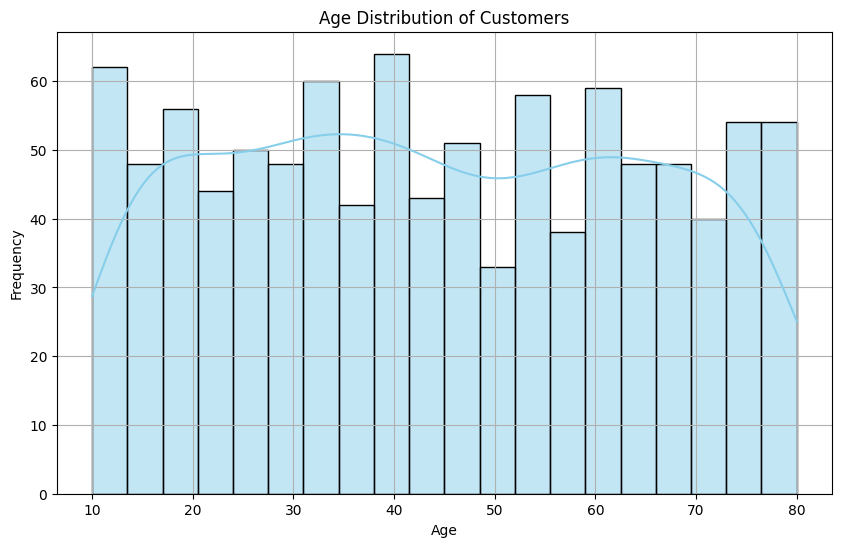

In [ ]:
# 고객 연령 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(cus['age'], bins=20, kde=True, color='skyblue')
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Q2. df를 수정하여 5가지 이상의 인사이트를 포함한 데이터 셋으로 변환하세요

In [ ]:
# 인사이트 삽입
# 무언가는 판매량이 늘었는데 무언가는 판매량이 줄었다.

# pivot으로 판매성장률 등을 구할 수도 있다.
# 상품별 변동률 산출 등


#### Q3. df 를 탐색적 분석을 통하여 인사이트를 도출하세요.